In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

import torch

In [22]:

# Autocorrelation computation
# From https://github.com/fjxmlzn/DoppelGANger/issues/20#issuecomment-858234890
EPS = 1e-8

def autocorr(X, Y):
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r


def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
        autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j],
                                                  feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

In [3]:
# Read smart home data from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
sensor_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")
sensor_df["datetime"] = pd.to_datetime(sensor_df["date"])
sensor_df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,datetime
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,2016-01-11 17:00:00
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,2016-01-11 17:10:00
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,2016-01-11 17:20:00
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,2016-01-11 17:30:00
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,2016-01-11 17:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,2016-05-27 17:20:00
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2016-05-27 17:30:00
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,2016-05-27 17:40:00
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,2016-05-27 17:50:00


In [67]:
# Use 4 temperature columns for this model
COLUMNS = ["T1", "T2", "T3", "T_out"]

train_df = sensor_df[["datetime"] + COLUMNS]
train_df

,datetime,T1,T2,T3,T_out
0,2016-01-11 17:00:00,19.890000,19.200000,19.790000,6.600000
1,2016-01-11 17:10:00,19.890000,19.200000,19.790000,6.483333
2,2016-01-11 17:20:00,19.890000,19.200000,19.790000,6.366667
3,2016-01-11 17:30:00,19.890000,19.200000,19.790000,6.250000
4,2016-01-11 17:40:00,19.890000,19.200000,19.790000,6.133333
...,...,...,...,...,...
19730,2016-05-27 17:20:00,25.566667,25.890000,27.200000,22.733333
19731,2016-05-27 17:30:00,25.500000,25.754000,27.133333,22.600000
19732,2016-05-27 17:40:00,25.500000,25.628571,27.050000,22.466667
19733,2016-05-27 17:50:00,25.500000,25.414000,26.890000,22.333333


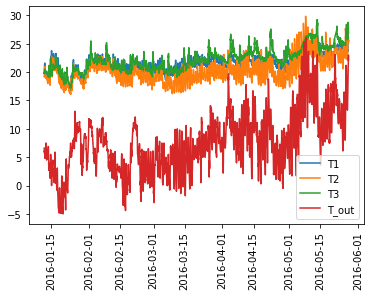

In [74]:
# Plot all 4 columns over the 4+ months of data
for c in COLUMNS:
    plt.plot(train_df["datetime"], train_df[c], label=c)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [6]:
# Chunk data into 1-day slices for DGAN training. So the DGAN model will
# synthesize 1 day of observations of the selected columns.
features = train_df.drop(columns=["datetime"]).to_numpy()
# Observations every 10 minutes, so 144 * 10 minutes = 1 day
n = features.shape[0] // 144
features = features[:(n*144),:].reshape(-1, 144, features.shape[1])

In [7]:
# Now we have data suitable for DGAN training
# Shape is (num examples, num time points, num features)
features.shape

(137, 144, 4)

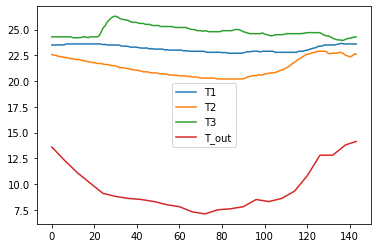

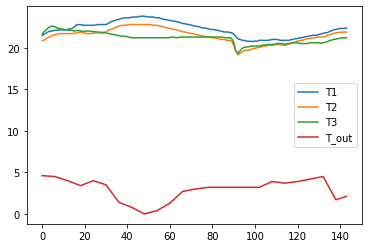

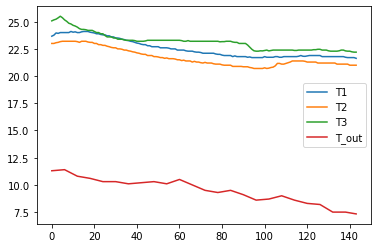

In [80]:
# Show some of the 1-day training examples
def plot_day(f):
    for i, c in enumerate(COLUMNS):
        plt.plot(f[:,i], label=c)
    plt.legend()
    plt.show()

plot_day(features[125,:,:])
plot_day(features[3,:,:])
plot_day(features[21,:,:])

In [9]:
# Recommended to train with a GPU
torch.cuda.is_available()

True

In [53]:
# Train DGAN model

model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=12,
    batch_size=min(features.shape[0], 1000),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    attribute_loss_coef=1.0,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    attribute_discriminator_learning_rate=1e-4,
    epochs=1000,
))

model.train_numpy(
    features,
    attribute_types=[OutputType.DISCRETE],
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

_, synthetic_features = model.generate_numpy(1000)

2022-06-14 21:45:18,059 : MainThread : INFO : epoch: 0
2022-06-14 21:45:18,095 : MainThread : INFO : epoch: 1
2022-06-14 21:45:18,127 : MainThread : INFO : epoch: 2
2022-06-14 21:45:18,158 : MainThread : INFO : epoch: 3
2022-06-14 21:45:18,189 : MainThread : INFO : epoch: 4
2022-06-14 21:45:18,220 : MainThread : INFO : epoch: 5
2022-06-14 21:45:18,253 : MainThread : INFO : epoch: 6
2022-06-14 21:45:18,286 : MainThread : INFO : epoch: 7
2022-06-14 21:45:18,318 : MainThread : INFO : epoch: 8
2022-06-14 21:45:18,351 : MainThread : INFO : epoch: 9
2022-06-14 21:45:18,385 : MainThread : INFO : epoch: 10
2022-06-14 21:45:18,418 : MainThread : INFO : epoch: 11
2022-06-14 21:45:18,450 : MainThread : INFO : epoch: 12
2022-06-14 21:45:18,482 : MainThread : INFO : epoch: 13
2022-06-14 21:45:18,514 : MainThread : INFO : epoch: 14
2022-06-14 21:45:18,546 : MainThread : INFO : epoch: 15
2022-06-14 21:45:18,578 : MainThread : INFO : epoch: 16
2022-06-14 21:45:18,609 : MainThread : INFO : epoch: 17
20

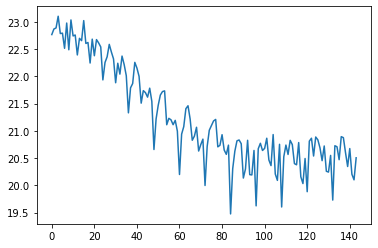

In [54]:
plt.plot(synthetic_features[52,:,1])

In [55]:
train_df = sensor_df[["T1", "T2", "T3", "T_out"]]
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=train_df.columns)

In [56]:
train_df.corr()

,T1,T2,T3,T_out
T1,1.000000,0.836834,0.892402,0.682846
T2,0.836834,1.000000,0.735245,0.792255
T3,0.892402,0.735245,1.000000,0.699417
T_out,0.682846,0.792255,0.699417,1.000000


In [57]:
synthetic_df.corr()

,T1,T2,T3,T_out
T1,1.000000,-0.857998,-0.494779,-0.347916
T2,-0.857998,1.000000,0.545962,0.460980
T3,-0.494779,0.545962,1.000000,0.270773
T_out,-0.347916,0.460980,0.270773,1.000000


In [49]:

synthetic_autocorr = get_autocorr(synthetic_features)

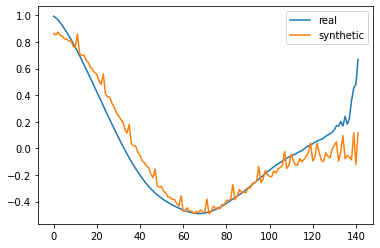

In [50]:
plt.plot(real_autocorr, label="real")
plt.plot(synthetic_autocorr, label="synthetic")
plt.legend()